## Frequency based ranking

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the CSV file (whitespace-delimited)
csv_path = "C:\\Users\\aditi\\Downloads\\dbmopp_dataset_perf.csv"
df = pd.read_csv(csv_path, sep='\s+')

In [3]:
# Set budgets and bootstrap parameters
budgets = [5000, 10000, 30000, 50000]
n_iterations = 1000
noise_std = 1e-4  # Standard deviation for Gaussian noise

In [9]:
# Store results for all budgets
all_results = []
mean_perf = []

In [10]:

# Loop over each budget
for budget_level in budgets:
    df_budget = df[df['budget'] == budget_level]
    if df_budget.empty:
        print(f"No data for budget {budget_level}, skipping...")
        continue

    algo_rank_counts = defaultdict(lambda: [0] * 4)  # 4 possible ranks

    for _ in range(n_iterations):
        # Bootstrap resample
        sample = resample(df_budget, replace=True, n_samples=len(df_budget))

        # Mean hypervolume per algorithm
        mean_scores = sample.groupby('algo')['hypervolume'].mean().reset_index()
        # store mean performance
        mean_perf.append(mean_scores)

        # Rank algorithms by descending hypervolume
        ranked = mean_scores.sort_values(by='hypervolume', ascending=False).reset_index(drop=True)

        for i, row in ranked.iterrows():
            algo_rank_counts[row['algo']][i] += 1

    # Build results for this budget
    algorithms = sorted(algo_rank_counts.keys())
    result = {
        'Budget': [budget_level] * len(algorithms),
        'Algorithm': algorithms
    }

    for rank in range(4):
        result[f'Rank {rank+1} Frequency'] = [
            algo_rank_counts[algo][rank] / n_iterations for algo in algorithms
        ]

    all_results.append(pd.DataFrame(result))

# Combine and reset index
final_df = pd.concat(all_results, ignore_index=True)
final_df.drop_duplicates(inplace=True)
final_df.reset_index(drop=True, inplace=True)
perf_df = pd.concat(mean_perf)
# Group by budget and show clean summary
for budget in sorted(final_df['Budget'].unique()):
    print(f"\n Results for Budget = {budget}")
    display(final_df[final_df['Budget'] == budget])




 Results for Budget = 5000


,Budget,Algorithm,Rank 1 Frequency,Rank 2 Frequency,Rank 3 Frequency,Rank 4 Frequency
0,5000,IBEA,1.0,0.0,0.0,0.0
1,5000,MOEAD,0.0,1.0,0.0,0.0
2,5000,NSGAII,0.0,0.0,1.0,0.0
3,5000,Random,0.0,0.0,0.0,1.0



 Results for Budget = 10000


,Budget,Algorithm,Rank 1 Frequency,Rank 2 Frequency,Rank 3 Frequency,Rank 4 Frequency
4,10000,IBEA,1.0,0.0,0.0,0.0
5,10000,MOEAD,0.0,0.0,1.0,0.0
6,10000,NSGAII,0.0,1.0,0.0,0.0
7,10000,Random,0.0,0.0,0.0,1.0



 Results for Budget = 30000


,Budget,Algorithm,Rank 1 Frequency,Rank 2 Frequency,Rank 3 Frequency,Rank 4 Frequency
8,30000,IBEA,1.0,0.0,0.0,0.0
9,30000,MOEAD,0.0,0.0,0.0,1.0
10,30000,NSGAII,0.0,1.0,0.0,0.0
11,30000,Random,0.0,0.0,1.0,0.0



 Results for Budget = 50000


,Budget,Algorithm,Rank 1 Frequency,Rank 2 Frequency,Rank 3 Frequency,Rank 4 Frequency
12,50000,IBEA,1.0,0.0,0.0,0.0
13,50000,MOEAD,0.0,0.0,0.0,1.0
14,50000,NSGAII,0.0,1.0,0.0,0.0
15,50000,Random,0.0,0.0,1.0,0.0


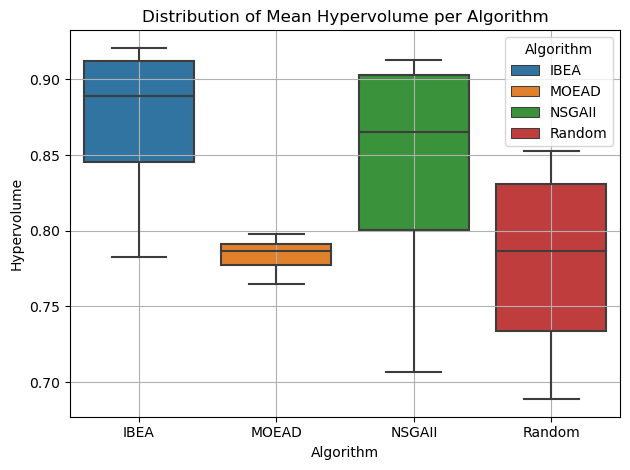

In [12]:

# Use a consistent color palette
palette = {
    'IBEA': '#1f77b4',
    'MOEAD': '#ff7f0e',
    'NSGAII': '#2ca02c',
    'Random': '#d62728'
}

sns.boxplot(x='algo', y='hypervolume', hue='algo', data=perf_df, palette=palette, dodge=False)

plt.title("Distribution of Mean Hypervolume per Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Hypervolume")
plt.legend(title="Algorithm", loc='best')  # Add legend with title
plt.grid(True)
plt.tight_layout()
plt.show()

## Using autorank for all budgets

        meanrank      mean       std  ci_lower  ci_upper effect_size  \
Random       4.0  0.692620  0.001415  0.692509  0.692732         0.0   
NSGAII       3.0  0.711711  0.001488  0.711594  0.711829  -13.151154   
MOEAD        2.0  0.769446  0.001534  0.769325  0.769568  -52.064562   
IBEA         1.0  0.786702  0.001330  0.786597  0.786807   -68.53107   

         magnitude effect_size_above magnitude_above  
Random  negligible               0.0      negligible  
NSGAII       large        -13.151154           large  
MOEAD        large        -38.206242           large  
IBEA         large        -12.020142           large  

 AutoRank Statistical Summary for Budget = 5000
The statistical analysis was conducted for 4 populations with 1000 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.380). Therefore, we assume that all populations ar

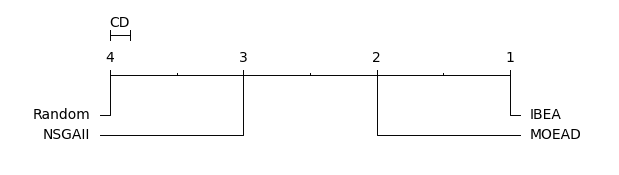

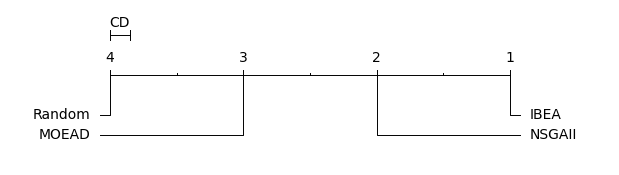

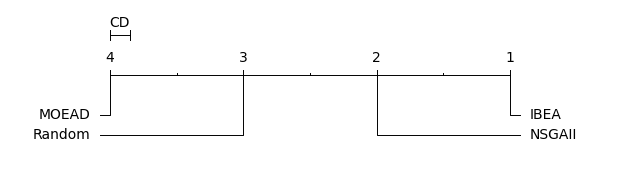

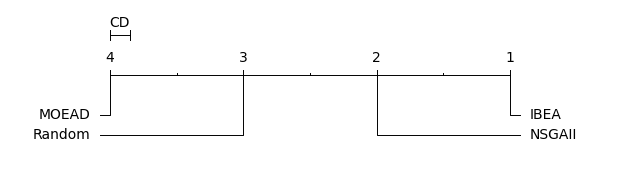

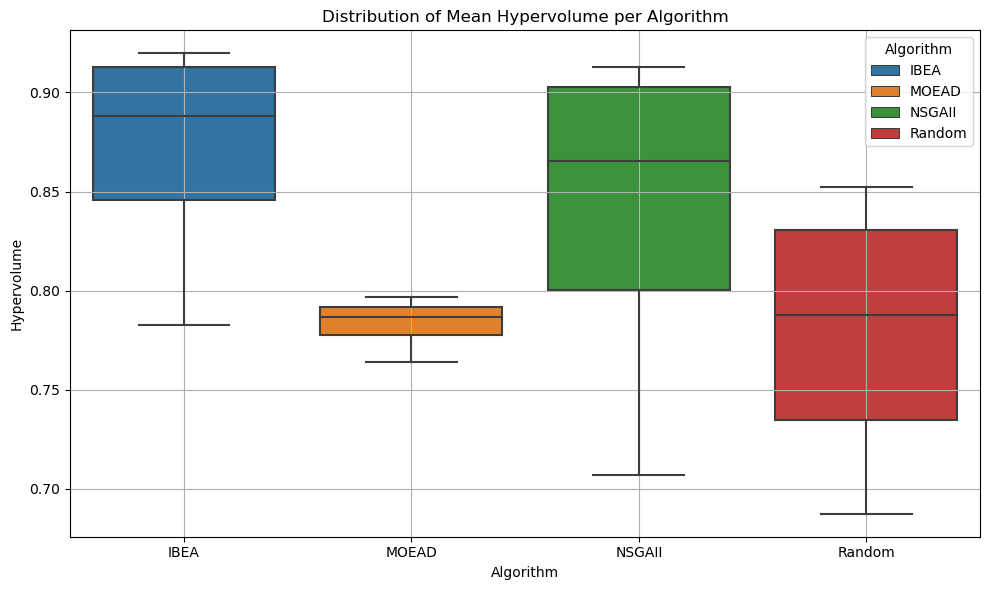

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from collections import defaultdict
from autorank import autorank, create_report, plot_stats

# Load the CSV file (whitespace-delimited)
csv_path = "C:\\Users\\aditi\\Downloads\\dbmopp_dataset_perf.csv"
df = pd.read_csv(csv_path, sep='\s+')

# Set budgets and bootstrap parameters
budgets = [5000, 10000, 30000, 50000]
n_iterations = 1000
noise_std = 1e-4  # Standard deviation for Gaussian noise

# Store results for all budgets
all_results = []
mean_perf = []

# Loop over each budget
for budget_level in budgets:
    df_budget = df[df['budget'] == budget_level]
    if df_budget.empty:
        print(f"No data for budget {budget_level}, skipping...")
        continue

    algo_rank_counts = defaultdict(lambda: [0] * 4)  # 4 possible ranks
    local_mean_perf = []

    for _ in range(n_iterations):
        # Bootstrap resample
        sample = resample(df_budget, replace=True, n_samples=len(df_budget))

        # Add Gaussian noise
        sample = sample.copy()
        sample['hypervolume'] += np.random.normal(0, noise_std, size=len(sample))

        # Mean hypervolume per algorithm
        mean_scores = sample.groupby('algo')['hypervolume'].mean().reset_index()
        local_mean_perf.append(mean_scores)

        # Rank algorithms by descending hypervolume
        ranked = mean_scores.sort_values(by='hypervolume', ascending=False).reset_index(drop=True)

        for i, row in ranked.iterrows():
            algo_rank_counts[row['algo']][i] += 1

    mean_perf.extend(local_mean_perf)

    # Build results for this budget
    algorithms = sorted(algo_rank_counts.keys())
    result = {
        'Budget': [budget_level] * len(algorithms),
        'Algorithm': algorithms
    }

    for rank in range(4):
        result[f'Rank {rank+1} Frequency'] = [
            algo_rank_counts[algo][rank] / n_iterations for algo in algorithms
        ]

    all_results.append(pd.DataFrame(result))

    # --- AutoRank Section ---
    algo_scores_matrix = defaultdict(list)
    for df_iter in local_mean_perf:
        for _, row in df_iter.iterrows():
            algo_scores_matrix[row['algo']].append(row['hypervolume'])

    autorank_df = pd.DataFrame(algo_scores_matrix)

    try:
        result_stats = autorank(autorank_df, alpha=0.05, verbose=False)
        print(f"\n AutoRank Statistical Summary for Budget = {budget_level}")
        print(create_report(result_stats))
        plot_stats(result_stats)
    except Exception as e:
        print(f"AutoRank failed for budget {budget_level}: {e}")

# Combine and reset index
final_df = pd.concat(all_results, ignore_index=True)
final_df.drop_duplicates(inplace=True)
final_df.reset_index(drop=True, inplace=True)

# Show final table grouped by 
print("Bootstrap Rank Frequencies by Budget")

print(final_df)

# Create performance dataframe for plotting
perf_df = pd.concat(mean_perf)

# Use a consistent color palette
palette = {
    'IBEA': '#1f77b4',
    'MOEAD': '#ff7f0e',
    'NSGAII': '#2ca02c',
    'Random': '#d62728'
}

# Boxplot of mean performances
plt.figure(figsize=(10, 6))
sns.boxplot(x='algo', y='hypervolume', hue='algo', data=perf_df, palette=palette, dodge=False)
plt.title("Distribution of Mean Hypervolume per Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Hypervolume")
plt.legend(title="Algorithm", loc='best')  # Add legend with title
plt.grid(True)
plt.tight_layout()
plt.show()


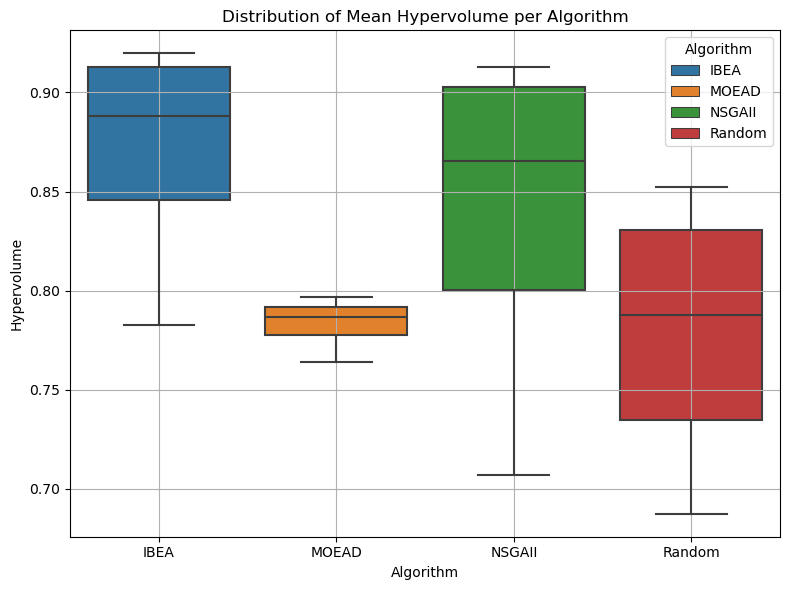

In [3]:
# Use a consistent color palette
palette = {
    'IBEA': '#1f77b4',
    'MOEAD': '#ff7f0e',
    'NSGAII': '#2ca02c',
    'Random': '#d62728'
}

# Boxplot of mean performances
plt.figure(figsize=(8, 6))
sns.boxplot(x='algo', y='hypervolume', hue='algo', data=perf_df, palette=palette, dodge=False)
plt.title("Distribution of Mean Hypervolume per Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Hypervolume")
plt.legend(title="Algorithm", loc='best')  # Add legend with title
plt.grid(True)
plt.tight_layout()
plt.show()

## Using autorank for all low and high budget

        meanrank      mean       std  ci_lower  ci_upper effect_size  \
Random     4.000  0.721710  0.000991  0.721632  0.721788         0.0   
NSGAII     2.999  0.771986  0.000977  0.771909  0.772064  -51.113036   
MOEAD      2.001  0.776304  0.001061   0.77622  0.776388  -53.189982   
IBEA       1.000  0.827232  0.000896  0.827161  0.827303 -111.714193   

         magnitude effect_size_above magnitude_above  
Random  negligible               0.0      negligible  
NSGAII       large        -51.113036           large  
MOEAD        large         -4.235003           large  
IBEA         large        -51.861488           large  

 AutoRank Report for Low Budget
The statistical analysis was conducted for 4 populations with 1000 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.251). Therefore, we assume that all populations are normal.
We app

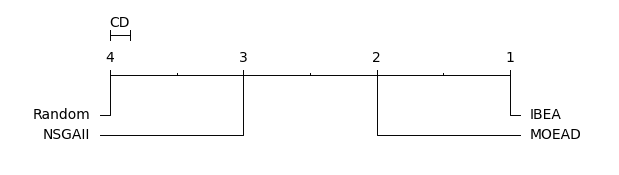

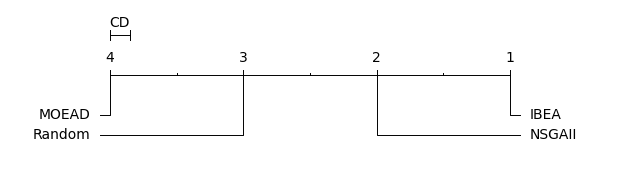

In [8]:
# Define budget groups
budget_groups = {
    'Low Budget': [5000, 10000],
    'High Budget': [30000, 50000]
}

group_results = []
group_perf = []

for group_name, group_budgets in budget_groups.items():
    df_group = df[df['budget'].isin(group_budgets)]
    algo_rank_counts = defaultdict(lambda: [0] * 4)
    local_mean_perf = []

    for _ in range(n_iterations):
        sample = resample(df_group, replace=True, n_samples=len(df_group))
        sample = sample.copy()
        sample['hypervolume'] += np.random.normal(0, noise_std, size=len(sample))
        mean_scores = sample.groupby('algo')['hypervolume'].mean().reset_index()
        local_mean_perf.append(mean_scores)

        ranked = mean_scores.sort_values(by='hypervolume', ascending=False).reset_index(drop=True)
        for i, row in ranked.iterrows():
            algo_rank_counts[row['algo']][i] += 1

   # Append with budget group label and algo column
    for df_iter in local_mean_perf:
        df_iter = df_iter.copy()
        df_iter['Budget Group'] = group_name
        group_perf.append(df_iter)


    algorithms = sorted(algo_rank_counts.keys())
    result = {
        'Budget Group': [group_name] * len(algorithms),
        'Algorithm': algorithms
    }
    for rank in range(4):
        result[f'Rank {rank+1} Frequency'] = [
            algo_rank_counts[algo][rank] / n_iterations for algo in algorithms
        ]

    group_results.append(pd.DataFrame(result))

    # AutoRank per group
    algo_scores_matrix = defaultdict(list)
    for df_iter in local_mean_perf:
        for _, row in df_iter.iterrows():
            algo_scores_matrix[row['algo']].append(row['hypervolume'])

    autorank_df = pd.DataFrame(algo_scores_matrix)

    try:
        result_stats = autorank(autorank_df, alpha=0.05, verbose=False)
        print(f"\n AutoRank Report for {group_name}")
        print(create_report(result_stats))
        plot_stats(result_stats)
    except Exception as e:
        print(f"AutoRank failed for {group_name}: {e}")


None
